# Capstone Project
## Part 4 -  Speaker Identification Registration
 
In this part, we train another classifier model in order to learn the identity of the speaker for then to be applied within the diarisation process.


> Introduction

In [53]:
import pandas as pd
import numpy as np
import os
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

import librosa
import librosa.display
import IPython.display
import joblib

import capstone
import sktools
import importlib

plt.rcParams['figure.figsize'] = (15,5)

### File Prep

In [2]:
folder = 'data/class/train_sets/1m/'
chaitanya = folder + 'chaitanya_rao.wav'
jin = folder + 'jin_yang.wav'

adi = folder+ 'adi_krishnan.wav'
ismael = folder +'ismael_abufon.wav'
shivir = folder + 'shivir_pokharel.wav'
vidya = folder + 'vidya_nayak.wav'
wyatt = folder + 'wyatt_watson.wav'
yang = folder + 'yang_liu.wav'

files = [chaitanya, jin, adi, ismael, shivir, vidya, wyatt, yang]
labels = ['chaitanya_rao','jin_yang',
          'adi_krishnan','ismael_abufon',
         'shivir_pokharel','vidya_nayak',
         'wyatt_watson','yang_liu']
names_dict= {}

lb = preprocessing.LabelBinarizer()
lb.fit(labels)

LabelBinarizer()

### Mini EDA

(1, 2685) (1, 2685)


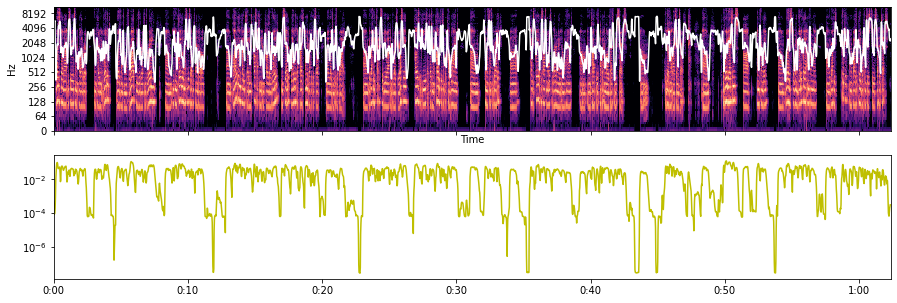

In [4]:
#plotting spectrum, energies and spectral centroid
fig, ax = plt.subplots(2,1, sharex=True)
path = wyatt
audio, sr = librosa.load(path, mono=True)
c1 = librosa.feature.spectral_centroid(audio, sr=sr)
S, phase = librosa.magphase(librosa.stft(y=audio))

times = librosa.times_like(c1)
rms = librosa.feature.rms(S=S)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis = 'time', ax=ax[0])
ax[0].plot(times, c1.T, label='Spectral Centroid',color='w')
ax[1].semilogy(times, rms[0], label='RMS energy',color='y')

plt.show()
IPython.display.Audio(audio, rate=sr)

In [5]:
#initialising variable
names_dict[0] = 'NA'
names_dict

{0: 'NA'}

### Feature Extraction

chaitanya_rao :  (3000, 46)


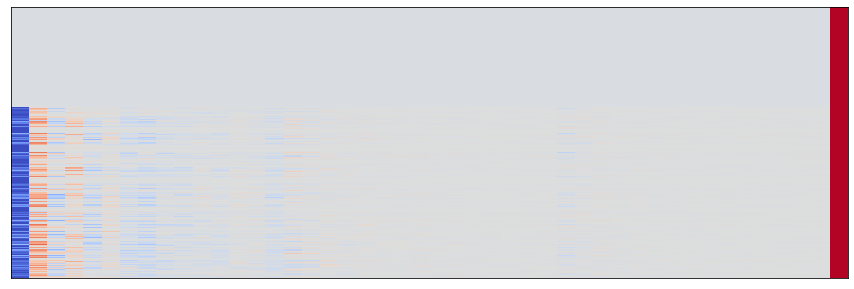

jin_yang :  (3000, 46)


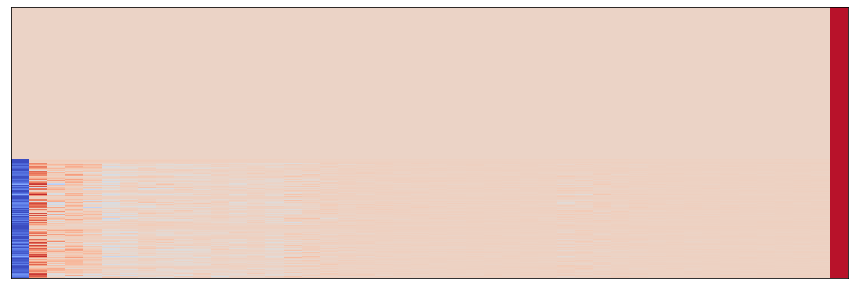

adi_krishnan :  (3000, 46)


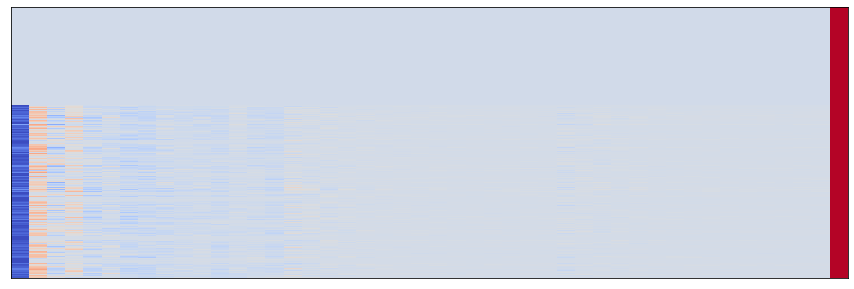

ismael_abufon :  (3000, 46)


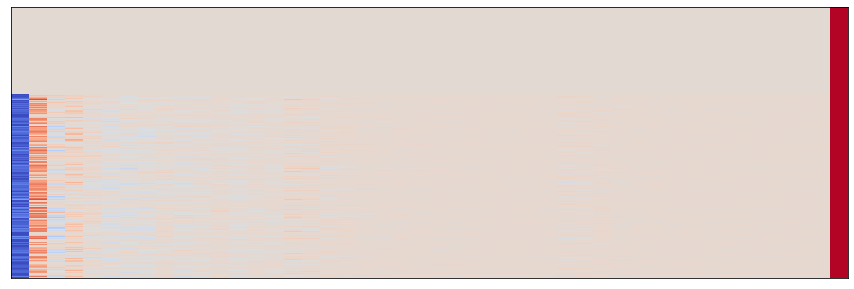

shivir_pokharel :  (3000, 46)


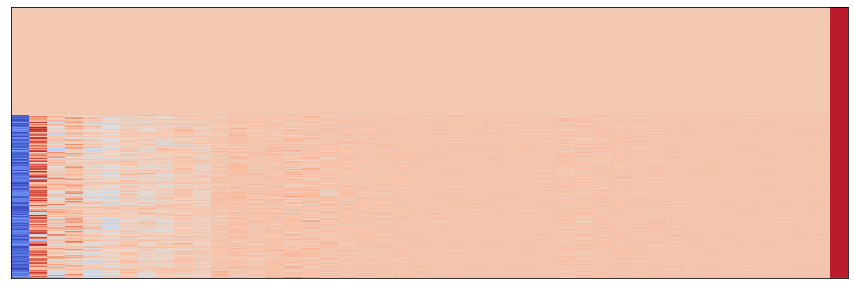

vidya_nayak :  (3000, 46)


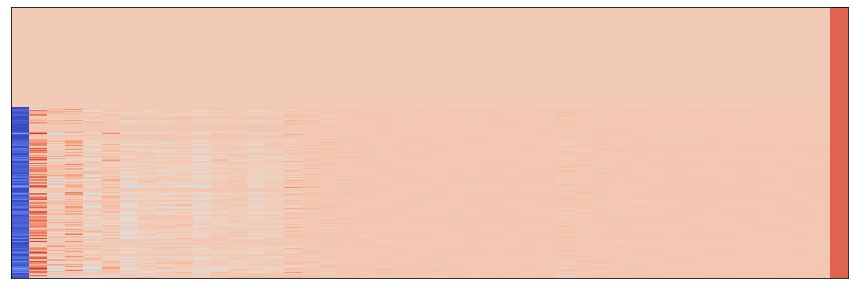

wyatt_watson :  (3000, 46)


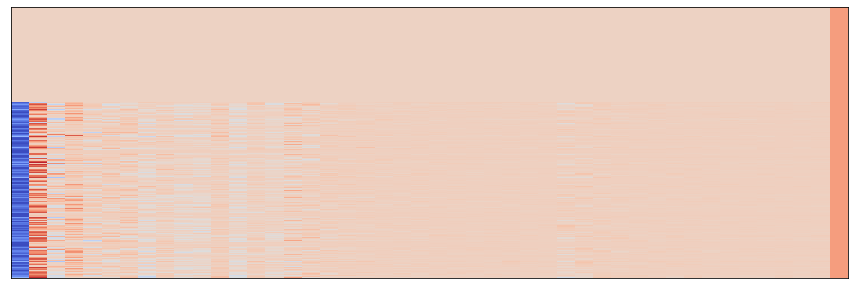

yang_liu :  (3000, 46)


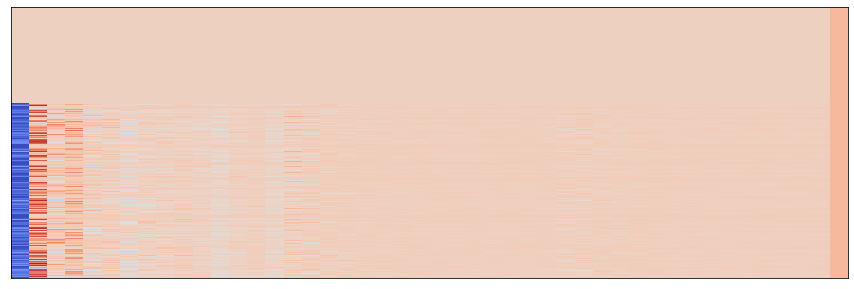

In [6]:
#Extract Features, create DF and plot
train_sets = {}
dfs = {}
full = []
for i in range(len(files)):
    train_sets[labels[i]], names_dict = capstone.audio.data_gen(files[i],3000, label=labels[i],names_dict=names_dict, flag=True, binarizer=lb)       
    dfs[labels[i]] = pd.DataFrame(train_sets[labels[i]])
    print(labels[i],': ',train_sets[labels[i]].shape)
    librosa.display.specshow(train_sets[labels[i]])
    plt.show()

### Data Prepping

In [10]:
#Combine into a single DF
df = pd.DataFrame()
for person in labels:
    df_sub = pd.DataFrame(train_sets[person])
    df = pd.concat((df,df_sub), ignore_index=True)

df = df[~(df ==0).any(axis=1)]
X_train = df.drop(45,axis=1).copy()
y_train = df[45]
df

0         1         2         3         4         5         6   \
0     -6.621219  0.356830  0.315237  0.288694  0.233607  0.164249  0.127318   
1     -6.622277  0.344478  0.312657  0.266907  0.215642  0.166721  0.125589   
2     -6.629531  0.231534  0.219788  0.202171  0.181164  0.159487  0.139630   
3     -6.631327  0.149849  0.149847  0.149844  0.149839  0.149833  0.149826   
4     -6.631327  0.149739  0.149737  0.149734  0.149729  0.149723  0.149716   
...         ...       ...       ...       ...       ...       ...       ...   
22934 -6.633242  0.150241  0.150241  0.150241  0.150241  0.150241  0.150241   
22935 -6.633242  0.150241  0.150241  0.150241  0.150241  0.150241  0.150241   
22936 -6.633242  0.150241  0.150241  0.150241  0.150241  0.150241  0.150241   
22937 -6.633242  0.150867  0.150867  0.150866  0.150866  0.150865  0.150864   
22938 -6.632421  0.162887  0.111895  0.141687  0.193694  0.179288  0.127924   

             7         8         9   ...        36        37        38  \
0      0.105759  0.075100  0.054143  ...  0.139874  0.135408  0.127607   
1      0.094675  0.074075  0.062913  ...  0.141824  0.137370  0.129591   
2      0.123530  0.112434  0.106906  ...  0.142649  0.138246  0.130554   
3      0.149817  0.149807  0.149795  ...  0.142621  0.138255  0.130630   
4      0.149707  0.149697  0.149686  ...  0.142672  0.138306  0.130681   
...         ...       ...       ...  ...       ...       ...       ...   
22934  0.150241  0.150241  0.150241  ...  0.149654  0.149466  0.152413   
22935  0.150241  0.150241  0.150241  ...  0.149654  0.149466  0.152413   
22936  0.150241  0.150241  0.150241  ...  0.149654  0.149466  0.152413   
22937  0.150863  0.150862  0.150861  ...  0.149364  0.149176  0.152124   
22938  0.124862  0.173822  0.194693  ...  0.146525  0.146336  0.149300   

             39        40        41        42        43        44   45  
0      0.118629  0.122590  0.117782  0.122528  0.124821  0.127004  7.0  
1      0.120639  0.124590  0.119795  0.124527  0.126813  0.128990  7.0  
2      0.121702  0.125608  0.120868  0.125547  0.127807  0.129960  7.0  
3      0.121855  0.125727  0.121027  0.125666  0.127907  0.130041  7.0  
4      0.121906  0.125778  0.121078  0.125717  0.127958  0.130092  7.0  
...         ...       ...       ...       ...       ...       ...  ...  
22934  0.153667  0.151170  0.149183  0.151005  0.153322  0.152258  1.0  
22935  0.153667  0.151170  0.149183  0.151005  0.153322  0.152258  1.0  
22936  0.153667  0.151170  0.149183  0.151005  0.153322  0.152258  1.0  
22937  0.153378  0.150880  0.148893  0.150715  0.153032  0.151968  1.0  
22938  0.150560  0.148049  0.146052  0.147883  0.150213  0.149143  1.0  

[14722 rows x 46 columns]

### Model Creation & Training

In [97]:
clf1 = SVC(kernel = 'linear',C=5, probability=True)
clf2 = SVC(kernel = 'linear',C=10, probability=True)
clf3 = DecisionTreeClassifier(criterion='entropy',max_depth=5)
clf4 = DecisionTreeClassifier(criterion='entropy',max_depth=10)
clf5 = AdaBoostClassifier(n_estimators=10)
clf6 = AdaBoostClassifier(base_estimator= clf4, n_estimators=20)
prefix = 'output/ID/SVC5/'

models = [clf1,clf2,clf3,clf4,clf5]

CPU times: user 55.4 s, sys: 382 ms, total: 55.8 s
Wall time: 55.8 s


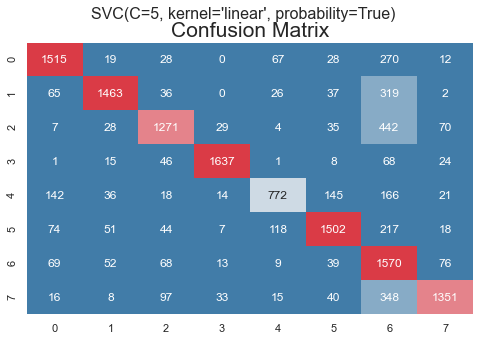

In [56]:
%%time
name ='SVC5'
prefix = f'output/ID/{name}/'
SVC_c5 = sktools.modelling.mono_modeler(clf1, X_train,y_train, plot_save=True,
                                        s_prefix=prefix, sub_folder_level=3,
                                        multi_class=True, figsize=[8,5], pickle=True)

CPU times: user 1min 1s, sys: 573 ms, total: 1min 2s
Wall time: 1min 3s


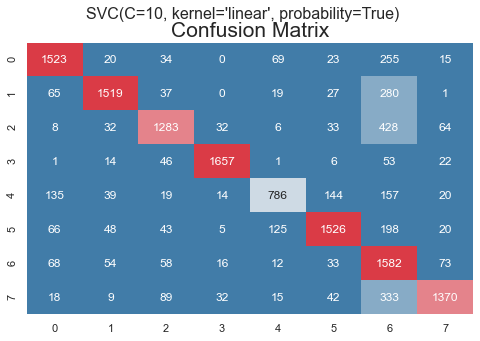

In [64]:
%%time
name ='SVC10'
prefix = f'output/ID/{name}/'
SVC_c10 = sktools.modelling.mono_modeler(clf2, X_train,y_train, plot_save=True,
                                        s_prefix=prefix, sub_folder_level=3,
                                        multi_class=True, figsize=[8,5], pickle=True)

CPU times: user 1.52 s, sys: 62.8 ms, total: 1.58 s
Wall time: 1.36 s


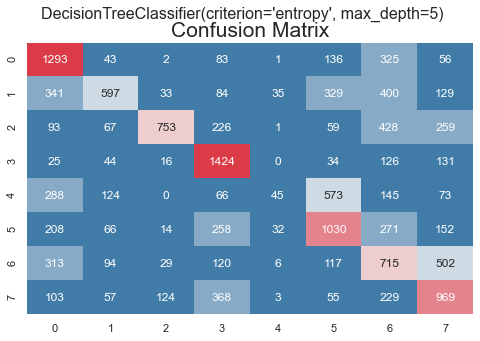

In [65]:
%%time
name ='Tree5'
prefix = f'output/ID/{name}/'
Tree5 = sktools.modelling.mono_modeler(clf3, X_train,y_train, plot_save=True,
                                        s_prefix=prefix, sub_folder_level=3,
                                        multi_class=True, figsize=[8,5],pickle=True)

CPU times: user 2.26 s, sys: 69.3 ms, total: 2.33 s
Wall time: 2.11 s


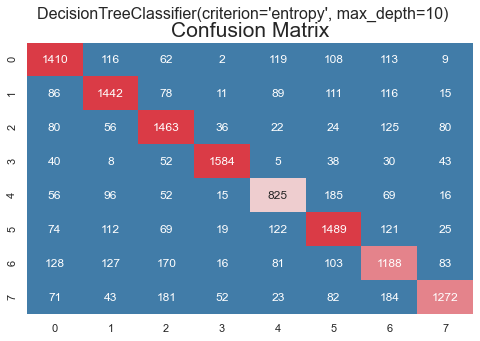

In [78]:
%%time
name ='Tree10'
prefix = f'output/ID/{name}/'
Tree10 = sktools.modelling.mono_modeler(clf4, X_train,y_train, plot_save=True,
                                        s_prefix=prefix, sub_folder_level=3,
                                        multi_class=True, figsize=[8,5], pickle=True)

CPU times: user 1.46 s, sys: 51.9 ms, total: 1.51 s
Wall time: 1.28 s


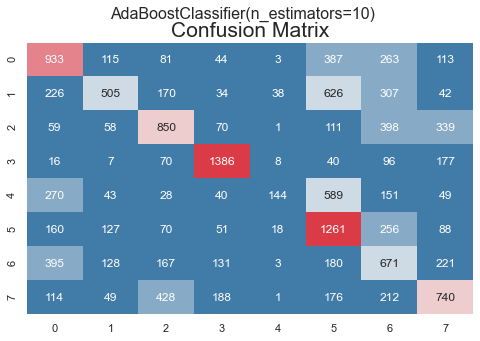

In [101]:
%%time
name ='Ada10'
prefix = f'output/ID/{name}/'
Ada110 = sktools.modelling.mono_modeler(clf5, X_train,y_train, plot_save=True,
                                        s_prefix=prefix, sub_folder_level=3,
                                        multi_class=True, figsize=[8,5], pickle=True)

CPU times: user 40 s, sys: 337 ms, total: 40.3 s
Wall time: 40.4 s


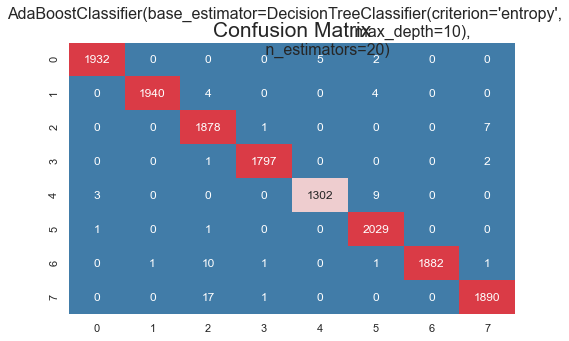

In [100]:
%%time
name ='Ada1020'
prefix = f'output/ID/{name}/'
Ada1020 = sktools.modelling.mono_modeler(clf6, X_train,y_train, plot_save=True,
                                        s_prefix=prefix, sub_folder_level=3,
                                        multi_class=True, figsize=[8,5], pickle=True)

> -  A pickle/joblib file was saved per training iteration

### Making Predictions per model

In [68]:
#Making list of files
sources = 'data/class/test_sets/'
#sources = 'data/debug/'
source_list = [os.path.join(sources,fname) for fname in
              os.listdir(sources) if fname.endswith('.wav')] 

In [104]:
%%time
SVC5_out = capstone.audio.id_me(source_list, clf1,names_dict)
SVC10_out = capstone.audio.id_me(source_list, clf2,names_dict)
Tree5_out = capstone.audio.id_me(source_list, clf3,names_dict)
Tree10_out = capstone.audio.id_me(source_list, clf4,names_dict)
Ada110_out = capstone.audio.id_me(source_list, clf5,names_dict)
Ada1020_out = capstone.audio.id_me(source_list, clf6,names_dict)

CPU times: user 6.16 s, sys: 462 ms, total: 6.62 s
Wall time: 4.61 s


In [71]:
SVC5_out

id          speaker         filename  \
0  4.0  shivir_pokharel  shivir_pokharel   
1  1.0         yang_liu         yang_liu   
2  2.0     wyatt_watson     wyatt_watson   
3  7.0    chaitanya_rao    chaitanya_rao   
4  3.0      vidya_nayak      vidya_nayak   
5  8.0     adi_krishnan     adi_krishnan   

                                                conf  
0  {1.0: 0.005607476635514018, 2.0: 0.00186915887...  
1  {1.0: 0.7878426698450537, 2.0: 0.0321811680572...  
2  {1.0: 0.028532608695652172, 2.0: 0.69972826086...  
3  {1.0: 0.03885480572597137, 2.0: 0.038854805725...  
4  {1.0: 0.03322784810126582, 2.0: 0.069620253164...  
5  {1.0: 0.024009603841536616, 2.0: 0.00480192076...

In [72]:
SVC10_out


id          speaker         filename  \
0  4.0  shivir_pokharel  shivir_pokharel   
1  1.0         yang_liu         yang_liu   
2  2.0     wyatt_watson     wyatt_watson   
3  7.0    chaitanya_rao    chaitanya_rao   
4  3.0      vidya_nayak      vidya_nayak   
5  8.0     adi_krishnan     adi_krishnan   

                                                conf  
0  {1.0: 0.003738317757009346, 2.0: 0.00186915887...  
1  {1.0: 0.799761620977354, 2.0: 0.03337306317044...  
2  {1.0: 0.02309782608695652, 2.0: 0.705163043478...  
3  {1.0: 0.03680981595092025, 2.0: 0.034764826175...  
4  {1.0: 0.04113924050632911, 2.0: 0.075949367088...  
5  {1.0: 0.028811524609843937, 2.0: 0.01200480192...

In [73]:
Tree5_out

id          speaker         filename  \
0  4.0  shivir_pokharel  shivir_pokharel   
1  1.0         yang_liu         yang_liu   
2  2.0     wyatt_watson     wyatt_watson   
3  8.0     adi_krishnan    chaitanya_rao   
4  7.0    chaitanya_rao      vidya_nayak   
5  4.0  shivir_pokharel     adi_krishnan   

                                                conf  
0  {1.0: 0.005607476635514018, 2.0: 0.04299065420...  
1  {1.0: 0.6078665077473182, 2.0: 0.0536352800953...  
2  {1.0: 0.11684782608695653, 2.0: 0.326086956521...  
3  {1.0: 0.1492842535787321, 2.0: 0.0654396728016...  
4  {1.0: 0.05063291139240506, 2.0: 0.068037974683...  
5  {1.0: 0.057623049219687875, 2.0: 0.03961584633...

In [74]:
Tree10_out

id          speaker         filename  \
0  4.0  shivir_pokharel  shivir_pokharel   
1  1.0         yang_liu         yang_liu   
2  2.0     wyatt_watson     wyatt_watson   
3  7.0    chaitanya_rao    chaitanya_rao   
4  3.0      vidya_nayak      vidya_nayak   
5  8.0     adi_krishnan     adi_krishnan   

                                                conf  
0  {1.0: 0.029906542056074768, 2.0: 0.00747663551...  
1  {1.0: 0.5601907032181168, 2.0: 0.0727056019070...  
2  {1.0: 0.07880434782608696, 2.0: 0.479619565217...  
3  {1.0: 0.09815950920245399, 2.0: 0.104294478527...  
4  {1.0: 0.04746835443037975, 2.0: 0.156645569620...  
5  {1.0: 0.05042016806722689, 2.0: 0.043217286914...

In [105]:
Ada110_out

id          speaker         filename  \
0  4.0  shivir_pokharel  shivir_pokharel   
1  1.0         yang_liu         yang_liu   
2  6.0    ismael_abufon     wyatt_watson   
3  7.0    chaitanya_rao    chaitanya_rao   
4  3.0      vidya_nayak      vidya_nayak   
5  8.0     adi_krishnan     adi_krishnan   

                                                conf  
0  {1.0: 0.014953271028037384, 2.0: 0.00373831775...  
1  {1.0: 0.4922526817640048, 2.0: 0.0655542312276...  
2  {1.0: 0.051630434782608696, 2.0: 0.25407608695...  
3  {1.0: 0.14314928425357873, 2.0: 0.114519427402...  
4  {1.0: 0.028481012658227847, 2.0: 0.09810126582...  
5  {1.0: 0.062424969987995196, 2.0: 0.03601440576...

In [106]:
Ada1020_out

id          speaker         filename  \
0  4.0  shivir_pokharel  shivir_pokharel   
1  1.0         yang_liu         yang_liu   
2  2.0     wyatt_watson     wyatt_watson   
3  7.0    chaitanya_rao    chaitanya_rao   
4  3.0      vidya_nayak      vidya_nayak   
5  8.0     adi_krishnan     adi_krishnan   

                                                conf  
0  {1.0: 0.022429906542056073, 2.0: 0.00186915887...  
1  {1.0: 0.6162097735399285, 2.0: 0.0643623361144...  
2  {1.0: 0.036684782608695655, 2.0: 0.50815217391...  
3  {1.0: 0.049079754601226995, 2.0: 0.04907975460...  
4  {1.0: 0.03322784810126582, 2.0: 0.091772151898...  
5  {1.0: 0.010804321728691477, 2.0: 0.01320528211...

In [110]:
#summary generation

fits = [SVC_c5, SVC_c10, Tree5, Tree10, Ada110, Ada1020]
m_names = ['SVC_c5','SVC_c10','Tree5','Tree10','Ada110','Ada1020']


modelled = {}
for x in range(len(fits)):
    modelled[m_names[x]] = fits[x]
    
cols = ['fitted','accuracy','CM']
rescomp = sktools.modelling.results(modelled,cols)
rescomp

fitted  accuracy                                                 CM
0   SVC_c5  0.752683  [[1515, 19, 28, 0, 67, 28, 270, 12], [65, 1463...
1  SVC_c10  0.763891  [[1523, 20, 34, 0, 69, 23, 255, 15], [65, 1519...
2    Tree5  0.725173  [[1410, 114, 62, 4, 119, 108, 113, 9], [86, 14...
3   Tree10  0.724969  [[1410, 116, 62, 2, 119, 108, 113, 9], [86, 14...
4   Ada110  0.440837  [[933, 115, 81, 44, 3, 387, 263, 113], [226, 5...
5  Ada1020  0.995109  [[1932, 0, 0, 0, 5, 2, 0, 0], [0, 1940, 4, 0, ...

- SVC5 and SVC10 were the best performers along Tree5 and 10, which were very close.

- Tree10 was the second worst performer, so it's dropped

- Ada110 had a sub-optimal score and the output already seems to carry errors. So the model is dropped. This was equivalent as a Decision tree with depth 1

-- After reviewing the intial results another AdaBoost model was created using Tree10 as a base estimator, and now expanding to n:20, leading to a big increase in accuracy

The selected models are SVC_c10, Tree10 and Ada1020

>>>